# Извлечение информации

* Именованные сущности: LOC, ORG, PER, TIME, GPE, 
* Отношения: _parent_(PER, PER), _worksIn_(PER, ORG), _locatedIn_(ORG, LOC)
* Факты: _bornIn_(PER, LOC, TIME), _newEmployee_(PER, ORG, occupation, TIME)
* События: _bornIn_("born", PER, LOC, TIME), _newEmployee_(new, PER, ORG, occupation, TIME)

# Сегодня: извлечение именованных сущностей [named entity recognition, NER]
* общие идеи
* локальный классификатор: RandomForest
* классификаторы последовательностей: CRF, biLSTM-CRF, charLSTM-wordLSTM

## Разметка


|             | В    | Британии | недавно | скончался | ученый | Стивен | Хокинг | .     |
|-------------|------|----------|---------|-----------|--------|--------|--------|-------|
| POS         | PREP | PROPN    | ADV     | VERB      | NOUN   | PROPN  | PROPN  | PUNCT |
| IOB (NE)    | O    | B-LOC    | B-TIME  | O         | O      | B-PER  | I-PER  | O     |
| IOBES (NE)  | O    | S-LOC    | B-TIME  | O         | O      | B-PER  | E-PER  | O     |
| IOB (REL)   |  O   | B-LOC    |  O      | O        |   O    |   B-PER     | I-PER        |    O  |
| IOB (REL)   |  O   | B-LOC    |  O      | B-Trigger/Death  | O| B-PER        |    I-PER  |O  |

## Задача классификации последовательности [sequence labelling]

* $ \mathbf{x} = x_1, x_2, \ldots, x_n$, $x_i \in V$, $V$ - словарь
* $ \mathbf{y} = y_1, y_2, \ldots, y_n$, $x_y \in L$, $L$ - метки
* ${(\mathbf{x}^{(1)}, \mathbf{y}^{(1)}), (\mathbf{x}^{(2)}, \mathbf{y}^{(2)}), \ldots, (\mathbf{x}^{(m)}, \mathbf{y}^{(m)})}$ - обучающие данные


Задача: обучить классификатор $\mathbf{x} \rightarrow \mathbf{y}$


### Локальные методы
Задача: определить класс данного токена $x_i$ или данной группы или $n$-грамы $x_{i:j}$ (или данной пары токенов ( $(x_i, x_j) \in R?$ )
* Правила и словари
* Любой алгоритм классификации (Random Forest, Naive Bayes, ConvNets)

### Глобальные методы
Задача: определить лучшую последовательность меток: $\arg \max_{Y} P(Y|X)$
* Правила и словари
* Марковские модели максимальной энтропии [Maximum entropy Markov model, MEMM]
* Условные случайные поля [Conditional random field, CRF]
* Рекуррентные нейронные сети
* Структурированный метод опорных векторов [SVM$^{struct}$]

### Признаки для слов
* Регистр слова, есть ли строчные, заглавные буквы, аббревиатуры
* Префикс и суффикс слова
* Входит ли слово в словарь (например, список городов, имен, фамилий и др.)
* Часть речи слова, разбор слова
* Лемма или псевдооснова (стем) слова
* Синтаксические зависимости слова
* Семантическая роль слова
* Все тоже самое для левого и правого контекста 

### Признаки для групп или $n$-грам
* Удовлетворяет ли группа или $n$-грама морфологическому шаблону
* Есть ли в группе или $n$-граме специфическое слово?
* Входит ли группа или $n$-грама в каком-нибудь словарь?

### Оценки качества извлечения именованных сущностей
* macro-, macro-, precision, recall, f1-measure, accuracy 
* оценка на уровне токенов / групп

### Проблемы
1. Многозначность: Пушкин (PER/LOC), Paris Hilton (PER PER / LOC ORG);
2. Вложенность: [ректор [НИУ ВШЭ] [Я. И. Кузьминов]]
3. Кореференция: Москва/LOC - столица России/LOC. Она/? стоит на берегу [р. Москвы]/LOC. 

### Данные
* Английский: СoNLL 2003, OntosNotes 5.0, ACE, kaggle (GMB корпус)
* Русский: FactRuEval (очень странный корпус)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [60]:
from itertools import chain


import pandas as pd
import numpy as np

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer, classification_report
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV



from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


import eli5

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report


from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, concatenate, SpatialDropout1D

Using TensorFlow backend.


# Эксперименты

## Данные: kaggle (GMB корпус)

In [7]:
data = pd.read_csv("../data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

In [9]:
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [11]:
words = list(set(data["Word"].values))

In [12]:
n_words = len(words); n_words

35178

In [11]:
data["Tag"].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [13]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.data[self.data["Sentence #"] == "Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist()    
        except:
            self.empty = True
            return None, None, None

In [14]:
getter = SentenceGetter(data)
sent, pos, tag = getter.get_next()
print(sent, pos, tag)

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'] ['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


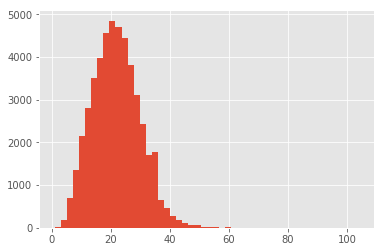

In [15]:
sentences = getter.sentences
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [18]:
class MemoryTagger(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        '''
        Expects a list of words as X and a list of tags as y.
        '''
        voc = {}
        self.tags = []
        for x, t in zip(X, y):
            if t not in self.tags:
                self.tags.append(t)
            if x in voc:
                if t in voc[x]:
                    voc[x][t] += 1
                else:
                    voc[x][t] = 1
            else:
                voc[x] = {t: 1}
        self.memory = {}
        for k, d in voc.items():
            self.memory[k] = max(d, key=d.get)
    
    def predict(self, X, y=None):
        '''
        Predict the the tag from memory. If word is unknown, predict 'O'.
        '''
        return [self.memory.get(x, 'O') for x in X]

#### Классификатор на правилах: ```MemoryTagger```
1. Запоминаем,сколько раз и каким тегом было помечено слово
2. Предсказываем самый частый тег
3. Не работает для несловарных слов

In [19]:
tagger = MemoryTagger()
tagger.fit(sent, tag)

In [20]:
print(sent)
print(tagger.predict(sent))

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [25]:
words = data["Word"].values.tolist()
tags = data["Tag"].values.tolist()
pred = cross_val_predict(estimator=MemoryTagger(), X=words, y=tags, cv=5)

In [27]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

             precision    recall  f1-score   support

      B-art       0.20      0.05      0.09       402
      B-eve       0.54      0.25      0.34       308
      B-geo       0.78      0.85      0.81     37644
      B-gpe       0.94      0.93      0.94     15870
      B-nat       0.42      0.28      0.33       201
      B-org       0.67      0.49      0.56     20143
      B-per       0.78      0.65      0.71     16990
      B-tim       0.87      0.77      0.82     20333
      I-art       0.04      0.01      0.01       297
      I-eve       0.39      0.12      0.18       253
      I-geo       0.73      0.58      0.65      7414
      I-gpe       0.62      0.45      0.52       198
      I-nat       0.00      0.00      0.00        51
      I-org       0.69      0.53      0.60     16784
      I-per       0.73      0.65      0.69     17251
      I-tim       0.58      0.13      0.21      6528
          O       0.97      0.99      0.98    887908

avg / total       0.94      0.95      0.94  

#### Случайный лес

Зададим признаковое пространство.

In [22]:
def feature_map(word):
    '''Simple feature map.'''
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

feature_map('Paris')

array([1, 0, 0, 5, 0, 1])

In [30]:
words = [feature_map(w) for w in data["Word"].values.tolist()]

In [31]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),
                         X=words, y=tags, cv=5)

In [32]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00       402
      B-eve       0.00      0.00      0.00       308
      B-geo       0.26      0.80      0.40     37644
      B-gpe       0.25      0.03      0.05     15870
      B-nat       0.00      0.00      0.00       201
      B-org       0.65      0.17      0.27     20143
      B-per       0.97      0.20      0.33     16990
      B-tim       0.29      0.32      0.30     20333
      I-art       0.00      0.00      0.00       297
      I-eve       0.00      0.00      0.00       253
      I-geo       0.00      0.00      0.00      7414
      I-gpe       0.00      0.00      0.00       198
      I-nat       0.00      0.00      0.00        51
      I-org       0.36      0.03      0.06     16784
      I-per       0.47      0.02      0.04     17251
      I-tim       0.50      0.06      0.11      6528
          O       0.97      0.98      0.97    887908

avg / total       0.88      0.87      0.86  

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


class FeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.memory_tagger = MemoryTagger()
        self.tag_encoder = LabelEncoder()
        self.pos_encoder = LabelEncoder()
        
    def fit(self, X, y):
        words = X["Word"].values.tolist()
        self.pos = X["POS"].values.tolist()
        tags = X["Tag"].values.tolist()
        self.memory_tagger.fit(words, tags)
        self.tag_encoder.fit(tags)
        self.pos_encoder.fit(self.pos)
        return self
    
    def transform(self, X, y=None):
        def pos_default(p):
            if p in self.pos:
                return self.pos_encoder.transform([p])[0]
            else:
                return -1
        
        pos = X["POS"].values.tolist()
        words = X["Word"].values.tolist()
        out = []
        for i in range(len(words)):
            w = words[i]
            p = pos[i]
            if i < len(words) - 1:
                wp = self.tag_encoder.transform(self.memory_tagger.predict([words[i+1]]))[0]
                posp = pos_default(pos[i+1])
            else:
                wp = self.tag_encoder.transform(['O'])[0]
                posp = pos_default(".")
            if i > 0:
                if words[i-1] != ".":
                    wm = self.tag_encoder.transform(self.memory_tagger.predict([words[i-1]]))[0]
                    posm = pos_default(pos[i-1])
                else:
                    wm = self.tag_encoder.transform(['O'])[0]
                    posm = pos_default(".")
            else:
                posm = pos_default(".")
                wm = self.tag_encoder.transform(['O'])[0]
            out.append(np.array([w.istitle(), w.islower(), w.isupper(), len(w), w.isdigit(), w.isalpha(),
                                 self.tag_encoder.transform(self.memory_tagger.predict([w]))[0],
                                 pos_default(p), wp, wm, posp, posm]))
        return out

Признаковое пространство : ```FeatureTransformer```
* w.istitle(), w.islower(), w.isupper(), len(w), w.isdigit(), w.isalpha(), 
* самый частый тег этого слова: memory_tagger.predict([w])
* самый частый тег и часть речи левого слова
* самый частый тег и часть речи правого слова

In [52]:
sent1 = data[0:24]
ft = FeatureTransformer()
ft.fit(sent1, None)
ft.transform(sent1)

[array([1, 0, 0, 9, 0, 1, 2, 7, 2, 2, 3, 0]),
 array([0, 1, 0, 2, 0, 1, 2, 3, 2, 2, 7, 7]),
 array([ 0,  1,  0, 13,  0,  1,  2,  7,  2,  2, 11,  3]),
 array([ 0,  1,  0,  4,  0,  1,  2, 11,  2,  2, 10,  7]),
 array([ 0,  1,  0,  7,  0,  1,  2, 10,  2,  2,  3, 11]),
 array([ 0,  1,  0,  7,  0,  1,  2,  3,  0,  2,  6, 10]),
 array([1, 0, 0, 6, 0, 1, 0, 6, 2, 2, 8, 3]),
 array([0, 1, 0, 2, 0, 1, 2, 8, 2, 0, 9, 6]),
 array([0, 1, 0, 7, 0, 1, 2, 9, 2, 2, 2, 8]),
 array([0, 1, 0, 3, 0, 1, 2, 2, 2, 2, 5, 9]),
 array([0, 1, 0, 3, 0, 1, 2, 5, 2, 2, 3, 2]),
 array([0, 1, 0, 2, 0, 1, 2, 3, 0, 2, 6, 5]),
 array([1, 0, 0, 4, 0, 1, 0, 6, 2, 2, 1, 3]),
 array([0, 1, 0, 3, 0, 1, 2, 1, 2, 0, 9, 6]),
 array([0, 1, 0, 6, 0, 1, 2, 9, 2, 2, 2, 1]),
 array([0, 1, 0, 3, 0, 1, 2, 2, 2, 2, 5, 9]),
 array([ 0,  1,  0, 10,  0,  1,  2,  5,  2,  2,  3,  2]),
 array([0, 1, 0, 2, 0, 1, 2, 3, 1, 2, 4, 5]),
 array([1, 0, 0, 7, 0, 1, 1, 4, 2, 2, 7, 3]),
 array([0, 1, 0, 6, 0, 1, 2, 7, 2, 1, 3, 4]),
 array([0, 1, 0, 4, 

In [35]:
pred = cross_val_predict(Pipeline([("feature_map", FeatureTransformer()), 
                                   ("clf", RandomForestClassifier(n_estimators=20, n_jobs=3))]),
                         X=data, y=tags, cv=5)

In [36]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

             precision    recall  f1-score   support

      B-art       0.16      0.07      0.10       402
      B-eve       0.40      0.26      0.32       308
      B-geo       0.83      0.86      0.84     37644
      B-gpe       0.98      0.93      0.95     15870
      B-nat       0.23      0.23      0.23       201
      B-org       0.73      0.64      0.68     20143
      B-per       0.82      0.75      0.79     16990
      B-tim       0.89      0.80      0.84     20333
      I-art       0.02      0.01      0.01       297
      I-eve       0.25      0.12      0.17       253
      I-geo       0.76      0.67      0.71      7414
      I-gpe       0.71      0.48      0.57       198
      I-nat       0.34      0.20      0.25        51
      I-org       0.73      0.68      0.70     16784
      I-per       0.85      0.75      0.80     17251
      I-tim       0.82      0.53      0.64      6528
          O       0.98      0.99      0.99    887908

avg / total       0.96      0.96      0.96  

#### Условные случайные поля


Лучшая последовательность тегов:  $ \hat{Y} =  \arg \max_Y P(Y|X) $

<img src="img/ner_seq1.png" width="400">

Лог-линейная модель:
* $F(y,x)$ - оценка качества одного разбора
* $\lambda$ - веса
* Глобальная нормализация:

$p(y|x, \lambda) =  \frac{exp{\sum_{i=1}^k \lambda_i F_i(y,x) }}{\sum_{y' \in C^n} exp { \sum_{i=1}^k \lambda_i F_i(y',x) }} $


* $F(y,x) = \sum_i f(y_{i-1}, y_i, x, i)$ - (транзиторный) признак, $f \in {0,1}$

Пример:

$f = 1 : y_{i-1} = $O, $y_i = $LOC, $x = $Пушкин


$f = 0 : иначе

#### Классификатор на основе CRF: ```crf_suite```
```word2features``` задает признаковое пространство для текущего слова, его левого и правого контекста.

In [53]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [56]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X[0][0]

{'+1:postag': 'IN',
 '+1:postag[:2]': 'IN',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'of',
 'BOS': True,
 'bias': 1.0,
 'postag': 'NNS',
 'postag[:2]': 'NN',
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': 'thousands',
 'word[-2:]': 'ds',
 'word[-3:]': 'nds'}

In [39]:
from sklearn_crfsuite import CRF

crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [41]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

             precision    recall  f1-score   support

      B-art       0.37      0.11      0.17       402
      B-eve       0.52      0.35      0.42       308
      B-geo       0.85      0.90      0.88     37644
      B-gpe       0.97      0.94      0.95     15870
      B-nat       0.66      0.37      0.47       201
      B-org       0.78      0.72      0.75     20143
      B-per       0.84      0.81      0.82     16990
      B-tim       0.93      0.88      0.90     20333
      I-art       0.11      0.03      0.04       297
      I-eve       0.34      0.21      0.26       253
      I-geo       0.82      0.79      0.80      7414
      I-gpe       0.92      0.55      0.69       198
      I-nat       0.61      0.27      0.38        51
      I-org       0.81      0.79      0.80     16784
      I-per       0.84      0.89      0.87     17251
      I-tim       0.83      0.76      0.80      6528
          O       0.99      0.99      0.99    887908

avg / total       0.97      0.97      0.97  

In [42]:
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [44]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,4.29,0.879,0.0,1.575,0.0,2.092,0.0,1.387,0.0,1.605,0.0,2.497,0.0,4.17,0.0,2.986,0.0
B-art,-0.014,0.0,8.442,0.0,0.0,-0.398,0.0,0.0,0.0,0.0,0.0,0.516,0.0,-0.844,0.0,0.336,0.0
I-art,-0.651,0.0,8.04,0.0,0.0,-0.702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.0,-0.684,0.0
B-eve,-0.753,0.0,0.0,0.0,7.956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.572,0.0
I-eve,-0.324,0.0,0.0,0.0,7.341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.621,0.0
B-geo,0.677,0.752,0.0,0.545,0.0,0.0,8.752,0.579,0.0,0.0,0.0,1.155,0.0,1.143,0.0,2.344,0.0
I-geo,-0.469,0.822,0.0,0.0,0.0,0.0,7.424,-1.366,0.0,0.0,0.0,-0.074,0.0,1.331,0.0,1.033,0.0
B-gpe,0.679,-1.609,0.0,-0.32,0.0,0.681,0.0,0.0,7.485,0.0,0.0,2.05,0.0,1.459,0.0,0.767,0.0
I-gpe,-0.298,0.0,0.0,0.0,0.0,-1.087,0.0,0.0,6.337,0.0,0.0,0.0,0.0,0.148,0.0,0.0,0.0
B-nat,-1.108,0.0,0.0,0.0,0.0,0.625,0.0,0.0,0.0,0.0,7.067,0.0,0.0,-0.305,0.0,-0.413,0.0


In [45]:
crf = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [46]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

In [47]:
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00       402
      B-eve       0.80      0.27      0.40       308
      B-geo       0.82      0.90      0.86     37644
      B-gpe       0.95      0.92      0.94     15870
      B-nat       0.69      0.09      0.16       201
      B-org       0.78      0.67      0.72     20143
      B-per       0.80      0.76      0.78     16990
      B-tim       0.93      0.83      0.88     20333
      I-art       0.00      0.00      0.00       297
      I-eve       0.64      0.12      0.20       253
      I-geo       0.81      0.73      0.77      7414
      I-gpe       0.93      0.37      0.53       198
      I-nat       0.00      0.00      0.00        51
      I-org       0.75      0.76      0.75     16784
      I-per       0.80      0.90      0.85     17251
      I-tim       0.84      0.67      0.74      6528
          O       0.99      0.99      0.99    887908

avg / total       0.96      0.97      0.96  

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None, c1=10, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [49]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,4.037,2.614,0.0,2.167,0.0,2.069,0.0,1.64,0.0,1.788,0.0,2.589,0.0,4.301,0.0,2.546,0.0
B-art,-0.185,0.0,7.041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-art,-0.398,0.0,7.378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-eve,-0.422,0.0,0.0,0.0,8.084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-eve,0.0,0.0,0.0,0.0,7.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-geo,1.012,0.0,0.0,0.0,0.0,0.0,10.604,0.969,0.0,0.0,0.0,0.788,0.0,0.502,0.0,2.172,0.0
I-geo,-0.991,0.0,0.0,0.0,0.0,0.0,7.889,-0.0,0.0,0.0,0.0,-0.005,0.0,-0.2,0.0,-0.144,0.0
B-gpe,1.064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.568,0.0,0.0,1.227,0.0,1.479,0.0,0.0,0.0
I-gpe,-0.259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-nat,-0.363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.942,0.0,0.0,0.0,0.0,0.0,0.0


#### Нейронные сети 

#### Модель biLSTM
* Вход: эмбеддинги слов
    * предобученные вектора glove, word2vec
    * случайно инициализированные вектора
    * эмбеддинги частей речи
    * эмбеддинги регистра
* Скрытый слой:
    * двунаправленная RNN с LSTM яйчеками
* Выход:
    * для каждого слова решается своя задача классификации

<img src="img/ner_seq2.png" width="400">

In [57]:
max_len = 50

words = list(set(data["Word"].values))
tags = list(set(data["Tag"].values))


word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

n_tags = len(tag2idx)

In [58]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
print(X[0])

[3399, 21057, 17912, 10886, 21038, 20410, 5482, 3851, 17604, 23629, 21443, 10561, 5954, 15428, 21391, 23629, 638, 21057, 10352, 24394, 18151, 4169, 11222, 11008]


In [62]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value= 0)
print(X[0])

[ 3399 21057 17912 10886 21038 20410  5482  3851 17604 23629 21443 10561
  5954 15428 21391 23629   638 21057 10352 24394 18151  4169 11222 11008
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [79]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
print(y[0])

[15 15 15 15 15 15  2 15 15 15 15 15  2 15 15 15 15 15  4 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]


In [85]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
y_tr = [to_categorical(i, num_classes=n_tags) for i in y_tr]

In [65]:
model = Sequential()
model.add(Embedding(input_dim=len(word2idx) + 1 , output_dim=50, input_length=max_len))
model.add(Bidirectional(LSTM(100, return_sequences = True, recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [86]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 150s - loss: 0.0320 - acc: 0.9904 - val_loss: 0.0297 - val_acc: 0.9912
Epoch 2/10
38846/38846 [==============================] - 149s - loss: 0.0297 - acc: 0.9911 - val_loss: 0.0307 - val_acc: 0.9908
Epoch 3/10
38846/38846 [==============================] - 149s - loss: 0.0279 - acc: 0.9917 - val_loss: 0.0311 - val_acc: 0.9906
Epoch 4/10
38846/38846 [==============================] - 149s - loss: 0.0261 - acc: 0.9922 - val_loss: 0.0321 - val_acc: 0.9905
Epoch 5/10
38846/38846 [==============================] - 148s - loss: 0.0244 - acc: 0.9927 - val_loss: 0.0337 - val_acc: 0.9903
Epoch 6/10
38846/38846 [==============================] - 149s - loss: 0.0229 - acc: 0.9931 - val_loss: 0.0345 - val_acc: 0.9900
Epoch 7/10
38846/38846 [==============================] - 147s - loss: 0.0215 - acc: 0.9935 - val_loss: 0.0355 - val_acc: 0.9898
Epoch 8/10
38846/38846 [========================

In [82]:
pred = model.predict(X_te)
pred_classes = pred.argmax(axis=-1)
report = flat_classification_report(y_pred=pred_classes, y_true=y_te)
print(report)

             precision    recall  f1-score   support

          1       0.81      0.89      0.85       724
          2       0.88      0.95      0.91      3862
          3       0.50      0.21      0.29        34
          4       0.97      0.94      0.96      1607
          5       1.00      0.48      0.65        27
          6       0.88      0.81      0.85       585
          7       0.69      0.36      0.47        25
          8       0.71      0.44      0.55        27
          9       0.91      0.85      0.88      1787
         10       0.92      0.92      0.92      1658
         11       0.91      0.90      0.91      1667
         12       0.00      0.00      0.00         5
         13       0.43      0.10      0.17        29
         14       0.64      0.41      0.50        17
         15       1.00      1.00      1.00    223681
         16       0.88      0.80      0.84      2052
         17       0.95      0.92      0.93      2013

avg / total       0.99      0.99      0.99  

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

#### Модель biLSTM-CRF

* Добавляем промежуточные полносвязные слои
* Добавляем слой CRF для глобального перевзвешивания

<img src="img/ner_seq3.png" width="400">

In [ ]:
from keras_contrib.layers import CRF

In [ ]:
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
model = Sequential()
model.add(Embedding(input_dim=len(word2idx) + 1 , output_dim=50, input_length=max_len))
model.add(Bidirectional(LSTM(100, return_sequences = True, recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(50, activation = 'softmax')))

crf = (CRF(n_tags))
model.add(crf)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

#### Модель biLSTM-wordLSTM

* Добавляем LSTM / CNN для посимвольного кодирования слова, таким образом учиываются особенности морфологии и словообразования

<img src="img/ner_seq4.png" width="400">

In [66]:
max_len_char = 10
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [67]:
max_len_char = 10
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [120]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post' )

In [69]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [70]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [72]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)
hist = pd.DataFrame(history.history)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 147s - loss: 0.4815 - acc: 0.8705 - val_loss: 0.1937 - val_acc: 0.9463
Epoch 2/10
38846/38846 [==============================] - 147s - loss: 0.1522 - acc: 0.9573 - val_loss: 0.1294 - val_acc: 0.9624
Epoch 3/10
38846/38846 [==============================] - 146s - loss: 0.1153 - acc: 0.9670 - val_loss: 0.1159 - val_acc: 0.9662
Epoch 4/10
38846/38846 [==============================] - 146s - loss: 0.1009 - acc: 0.9702 - val_loss: 0.1104 - val_acc: 0.9674
Epoch 5/10
38846/38846 [==============================] - 147s - loss: 0.0921 - acc: 0.9724 - val_loss: 0.1074 - val_acc: 0.9677
Epoch 6/10
38846/38846 [==============================] - 146s - loss: 0.0856 - acc: 0.9738 - val_loss: 0.1090 - val_acc: 0.9682
Epoch 7/10
38846/38846 [==============================] - 145s - loss: 0.0810 - acc: 0.9749 - val_loss: 0.1050 - val_acc: 0.9691
Epoch 8/10
38846/38846 [========================

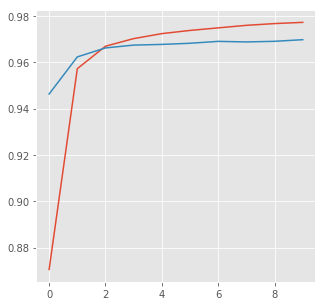

In [135]:
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [134]:
pred = model.predict([X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])
pred_classes = pred.argmax(axis=-1)
pred_classes
report = flat_classification_report(y_pred=pred_classes, y_true=y_te)
print(report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00    134255
          1       0.67      0.18      0.29        33
          2       0.81      0.71      0.76      2070
          3       0.50      0.02      0.04        49
          4       0.37      0.30      0.33        23
          5       0.96      0.94      0.95      1596
          6       0.82      0.86      0.84      1693
          7       0.84      0.91      0.87      3735
          8       0.83      0.87      0.85      1738
          9       0.33      0.40      0.36         5
         10       0.74      0.84      0.79       707
         11       0.40      0.99      0.57     89136
         12       0.93      0.87      0.90      2157
         13       0.81      0.79      0.80      1786
         14       0.00      0.00      0.00        42
         15       0.57      0.24      0.34        33
         16       0.75      0.73      0.74       726
         17       1.00      0.44      0.61   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Заключение

* SoTA: CNN - biLSTM - CRF
* Нужны большие объемы размеченных данных
* OpenSource решения:
    * keras + keras_contrib
    * iPavlov